# Clustering 

In [3]:
%matplotlib inline
import math
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr

In [4]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [5]:
stand_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

In [4]:
# Changing the size of the graphs 
#plt.rcParams['figure.figsize'] = [15,10]

In [5]:
#colors_list = ['#FB8369', '#FBDC69', '#A1FB69', '#69E4FB', '#6990FB','#C669FB','#FB6991']
#light_colors_list = ['#F5B4B4', '#F5B4DB', '#EFB4F5', '#C8B4F5', '#B4C9F5','#B4F5E2','#CDF5B4', '#F5F4B4']

In [6]:
df_new = pd.read_csv('df_new.csv', index_col=0)
df_new.head()

,word,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,web_corpus_freq
1,abbey,5,1.767767,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,0,22.010473
2,abbreviate,10,1.809143,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,0,17.096149
3,abdicate,8,2.047926,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,0,16.921411
4,abdication,10,1.961122,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,0,16.967395
5,abdomen,7,2.171175,5.486,5.441,6.606,6.235,4.636,5.457,3.529,4.600,0,20.507543


# 1- Preprocessing for Clustering

### 1.1- Saving df Standard Scaled values in 'df_scal' table as csv

In [7]:
#cols = [col for col in df.columns 
#       if col != 'word' and col != 'length' and col != 'polysemy'] # and col != 'web_corpus_freq' and col != 'length' 
#df_stand_scal = stand_scaler.fit_transform(df[cols].values)
#df_stand = pd.DataFrame(df_stand_scal)
##df_stand
##df_stand = df [['word', 'length', 'arousal', 'valence', 'dominance', 'concreteness', 'imageability', 
##                'familiarity', 'aoa', 'semsize', 'gender', 'polysemy', 'web_corpus_freq']]
#df_stand.rename(columns={'0': 'arousal', '1': 'valence', '2': 'dominance', '3': 'concreteness', '4': 'imageability', 
#                         '5': 'familiarity', '6': 'aoa', '7': 'semsize', '8': 'gender', '9': 'web_corpus_freq'})
#df_stand.columns = ['arousal', 'valence', 'dominance', 'concreteness', 'imageability', 
#                'familiarity', 'aoa', 'semsize', 'gender', 'web_corpus_freq']
#df_stand

In [8]:
# # Saved in table 'df_scal'
#df_stand.to_csv("df_stand.csv")

In [7]:
df_stand = pd.read_csv('df_stand.csv', index_col=0, skipinitialspace=True)
df_stand.head()
## Working only on continuous variables!! 

,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,web_corpus_freq
0,-1.500641,0.448362,-0.460975,0.935991,0.461439,-2.219056,0.844767,0.979334,-1.020821,-0.221199
1,-1.334147,0.105442,0.198189,-0.897275,-1.126278,-0.186458,1.140978,-1.423344,-0.195815,-2.077273
2,-0.373314,-0.852279,-0.748779,-0.840598,-1.610579,-1.487230,1.699408,0.546578,1.281291,-2.143269
3,-0.722602,-0.779304,-0.306628,-0.893077,-1.570281,-2.475817,1.840229,0.942129,0.545208,-2.125901
4,0.122626,0.257851,0.437252,1.425795,1.114257,-0.735044,1.071377,-0.579371,0.581024,-0.788835


In [8]:
df_stand = df_stand.drop(['concreteness','dominance', 'familiarity'], axis= 1)

In [9]:
cols = df_stand.columns
cols

Index(['arousal', 'valence', 'imageability', 'aoa', 'semsize', 'gender',
       'web_corpus_freq'],
      dtype='object')

In [10]:
df_stand_array = df_stand[cols].values

In [11]:
#rename
df_stand.rename(columns={'arousal': 'AROU', 'valence': 'VAL', 'imageability': 'IMAG', 'aoa': 'AOA', 'semsize': 'SIZE', 
                       'gender': 'GEND', 'web_corpus_freq': 'WCF'
                      })
df_stand.columns = ['AROU', 'VAL', 'IMAG', 'AOA', 'SIZE', 'GEND', 'WCF']
df_stand.head()

,AROU,VAL,IMAG,AOA,SIZE,GEND,WCF
0,-1.500641,0.448362,0.461439,0.844767,0.979334,-1.020821,-0.221199
1,-1.334147,0.105442,-1.126278,1.140978,-1.423344,-0.195815,-2.077273
2,-0.373314,-0.852279,-1.610579,1.699408,0.546578,1.281291,-2.143269
3,-0.722602,-0.779304,-1.570281,1.840229,0.942129,0.545208,-2.125901
4,0.122626,0.257851,1.114257,1.071377,-0.579371,0.581024,-0.788835


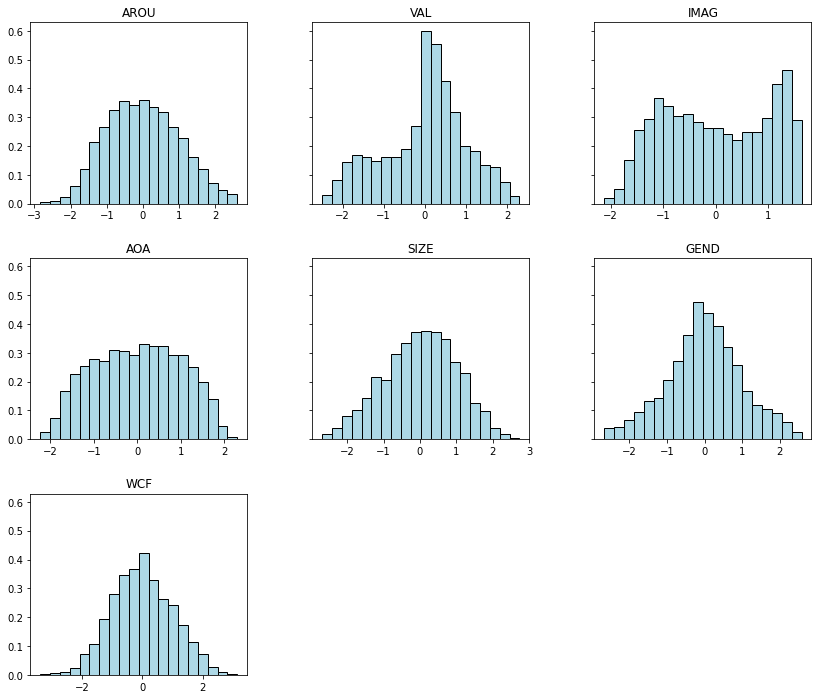

In [14]:
df_stand.hist(density = True, bins = 20, sharey = True, figsize=(14,12), grid=False, edgecolor = 'k', color = 'lightblue')
plt.show()
#plt.savefig(os.path.join('StandHist.png'), dpi=300, format='png', bbox_inches='tight')

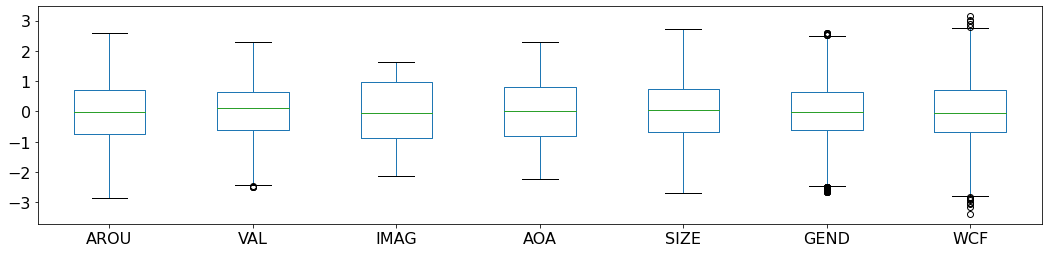

In [15]:
df_stand.plot.box(figsize = (18, 4))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()
#plt.savefig(os.path.join('StandBox.png'), dpi=300, format='png', bbox_inches='tight')
#[['AROU', 'VAL', 'IMAG', 
#         'AOA', 'SIZE', 'GEND']]

### 1.2 Saving df MinMax Scaled values in 'df_minmax' table as csv

In [16]:
## Working only on continuous variables!! 
#cols = [col for col in df.columns 
#       if col != 'word' and col != 'length' and col != 'polysemy'] # and col != 'web_corpus_freq'
#df_minmax_scal = minmax_scaler.fit_transform(df[cols].values)
#df_minmax = pd.DataFrame(df_minmax_scal)
#df_minmax
##df_scaled = df #[['word', 'arousal', 'valence', 'dominance', 'concreteness', 'imageability', 'familiarity', 'aoa', 'semsize', 'gender']]
#df_minmax.rename(columns={'0': 'arousal', '1': 'valence', '2': 'dominance', '3': 'concreteness', '4': 'imageability',
#                          '5': 'familiarity', '6': 'aoa', '7': 'semsize', '8': 'gender', '9': 'web_corpus_freq'})
#df_minmax.columns = ['arousal','valence','dominance','concreteness','imageability','familiarity','aoa','semsize','gender', 
#                    'web_corpus_freq']
#df_minmax

In [17]:
# #Saved in table 'df_minmax'
#df_minmax.to_csv("df_minmax.csv")

In [18]:
df_minmax = pd.read_csv('df_minmax.csv', index_col=0)
df_minmax.head()
## Working only on continuous variables!! 

,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,web_corpus_freq
0,0.246443,0.614163,0.412269,0.805356,0.688086,0.149612,0.679643,0.676540,0.313882,0.484572
1,0.277015,0.542676,0.543750,0.311203,0.264844,0.572336,0.745000,0.233339,0.471059,0.200062
2,0.453443,0.343026,0.354861,0.326481,0.135742,0.301811,0.868214,0.596713,0.752471,0.189946
3,0.389306,0.358239,0.443056,0.312335,0.146484,0.096213,0.899286,0.669677,0.612235,0.192608
4,0.544507,0.574448,0.591435,0.937382,0.862109,0.458245,0.729643,0.389019,0.619059,0.397561


In [19]:
cols = df_minmax.columns

In [20]:
df_minmax_array = df_minmax[cols].values

In [21]:
df_minmax = df_minmax.drop(['concreteness','dominance', 'familiarity'], axis= 1)
df_minmax.head()

,arousal,valence,imageability,aoa,semsize,gender,web_corpus_freq
0,0.246443,0.614163,0.688086,0.679643,0.676540,0.313882,0.484572
1,0.277015,0.542676,0.264844,0.745000,0.233339,0.471059,0.200062
2,0.453443,0.343026,0.135742,0.868214,0.596713,0.752471,0.189946
3,0.389306,0.358239,0.146484,0.899286,0.669677,0.612235,0.192608
4,0.544507,0.574448,0.862109,0.729643,0.389019,0.619059,0.397561


In [26]:
##rename
#df_minmax.rename(columns={'arousal': 'AROU', 'valence': 'VAL', 'imageability': 'IMAG', 'aoa': 'AOA', 'semsize': 'SIZE', 
#                       'gender': 'GEND', 'web_corpus_freq': 'WCF'
#                      })
#df_minmax.columns = ['AROU', 'VAL', 'IMAG', 'AOA', 'SIZE', 'GEND', 'WCF']
#df_minmax.head()

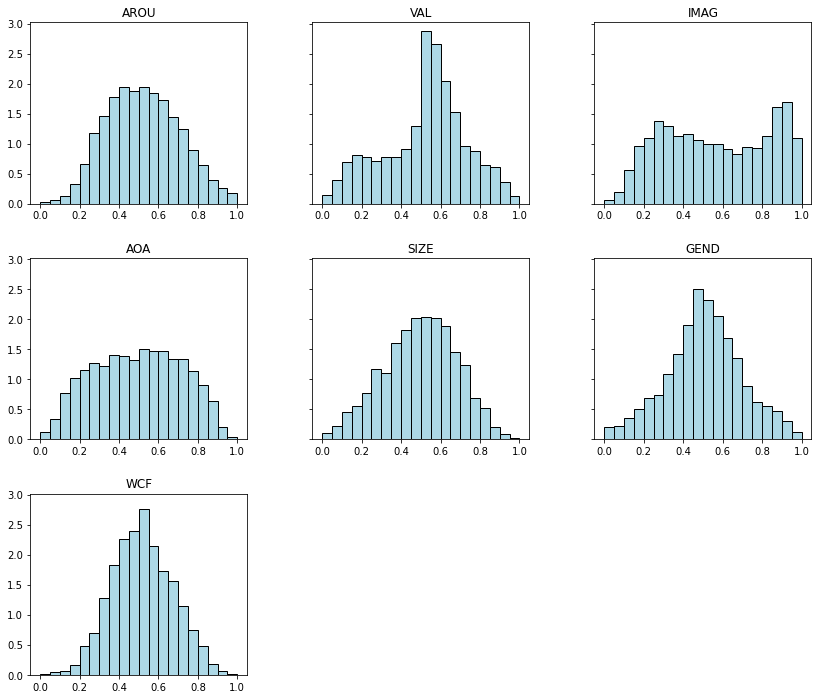

In [27]:
df_minmax.hist(density = True, bins = 20, sharey = True, figsize=(14,12), grid=False, edgecolor = 'k', color = 'lightblue')
plt.show()
#plt.savefig(os.path.join('MinMaxHist.png'), dpi=300, format='png', bbox_inches='tight') 

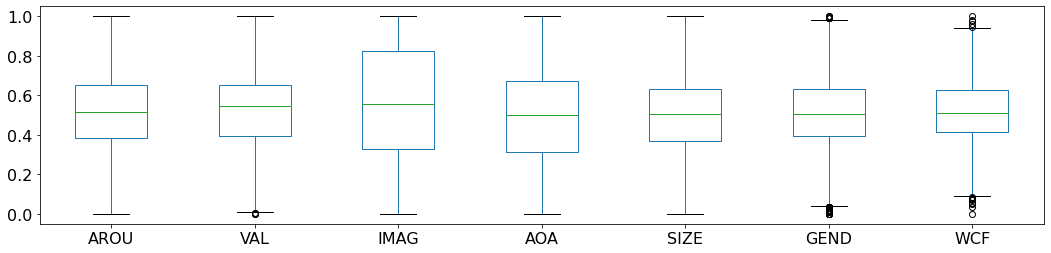

In [28]:
df_minmax[['AROU', 'VAL', 'IMAG', 
         'AOA', 'SIZE', 'GEND', 'WCF']].plot.box(figsize = (18, 4))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()
#plt.savefig(os.path.join('MinMaxBox.png'), dpi=300, format='png', bbox_inches='tight') 

# 2- K-Means (1st algorithm)

## 2.1- Using Stardard Scaled Values

In [29]:
kmeans = KMeans( n_clusters=3, n_init=10, max_iter=100 )
kmeans.fit(df_stand_array)

KMeans(max_iter=100, n_clusters=3)

In [30]:
kmeans.labels_

array([2, 2, 2, ..., 1, 1, 2])

In [31]:
df_new = pd.read_csv('df_new.csv', index_col=0)
df_new.head()

,word,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,web_corpus_freq
1,abbey,5,1.767767,5.781,4.667,5.906,5.344,3.324,5.177,5.121,3.303,0,22.010473
2,abbreviate,10,1.809143,5.250,5.235,3.286,3.177,5.121,5.543,2.667,3.971,0,17.096149
3,abdicate,8,2.047926,3.767,4.419,3.367,2.516,3.971,6.233,4.679,5.167,0,16.921411
4,abdication,10,1.961122,3.880,4.800,3.292,2.571,3.097,6.407,5.083,4.571,0,16.967395
5,abdomen,7,2.171175,5.486,5.441,6.606,6.235,4.636,5.457,3.529,4.600,0,20.507543


In [32]:
df_new = df_new.drop(['word', 'length', 'concreteness','dominance', 'familiarity', 'polysemy', 'web_corpus_freq'], axis= 1)
df_new.head()

,arousal,valence,imageability,aoa,semsize,gender
1,1.767767,5.781,5.344,5.177,5.121,3.303
2,1.809143,5.250,3.177,5.543,2.667,3.971
3,2.047926,3.767,2.516,6.233,4.679,5.167
4,1.961122,3.880,2.571,6.407,5.083,4.571
5,2.171175,5.486,6.235,5.457,3.529,4.600


In [33]:
cols = df_new.columns
cols

Index(['arousal', 'valence', 'imageability', 'aoa', 'semsize', 'gender'], dtype='object')

In [34]:
centers = kmeans.cluster_centers_

### Finding number of K

In [39]:
import matplotlib as matplot
import seaborn as sb
from sklearn.ensemble import IsolationForest
from sklearn import cluster, datasets
from sklearn.decomposition import PCA
from sklearn import metrics

In [ ]:
#df_stand_array

### SSE 

In [ ]:
#from sklearn.cluster import KMeans
sse_list_stand = list()
# n= 4357
# sqr(n)= 66
max_k = 66
for k in range(2, max_k + 1):
    kmeans=KMeans(n_clusters=k, n_init=20, max_iter=300)
    kmeans.fit(df_stand)
    sse = kmeans.inertia_
    sse_list_stand.append(sse)
#sse_list_stand

In [ ]:
plt.plot( sse_list_stand, marker='*')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('SSE by Standard Scaler', fontsize=20)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.axvline(4, color = "r") #, linestyle='--')                    # axv = vertical line
plt.show()
#plt.savefig(os.path.join('StandSSE.png'), dpi=300, format='png', bbox_inches='tight') 

In [ ]:
#from sklearn.cluster import KMeans
sse_list_minmax = list()
# n= 4357
# sqr(n)= 66
max_k = 66
for k in range(2, max_k + 1):
    kmeans=KMeans(n_clusters=k, n_init=20, max_iter=300)
    kmeans.fit(df_minmax)
    sse = kmeans.inertia_
    sse_list_minmax.append(sse)
#sse_list_minmax

In [ ]:
plt.plot( sse_list_minmax, marker='*')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.title('SSE by Minmax Scaler', fontsize=22)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.axvline(4, color = "r") #, linestyle='--'                    # axv = vertical line
plt.show()

### Silhouette scores

##### Standard Scaled

In [ ]:
from sklearn import metrics

k_test = range(2,25,1) # [2,...., 36]
silhouette_scores_stand = {}

for k in k_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(df_stand)
    labels_k = model_kmeans_k.labels_
    k_score_stand = metrics.silhouette_score(df_stand, labels_k)
    silhouette_scores_stand[k] = k_score_stand
    print("With k = ", k ,"   ", "S.Score:","  " , k_score_stand)
    
print("Done!")

In [ ]:
#silhouette_scores.values()

In [ ]:
plt.figure(figsize = (16,5))
plt.plot(np.array(list(silhouette_scores_stand.values())).astype(float))
plt.xticks(range(0,23,1), silhouette_scores_stand.keys())
plt.title("Silhouette Metric by Standard Scaler", fontsize = 20)
plt.xlabel("K",fontsize = 22)
plt.ylabel("Silhouette Score", fontsize = 22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axvline(1, color = "r")                   # axv = vertical line
plt.show()
#plt.savefig(os.path.join('StandSilhouette.png'), dpi=300, format='png', bbox_inches='tight') 

##### Minmax Scaled

In [ ]:
from sklearn import metrics

k_test = range(2,25,1) # [2,...., 36]
silhouette_scores_minmax = {}

for k in k_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(df_minmax)
    labels_k = model_kmeans_k.labels_
    k_score_minmax = metrics.silhouette_score(df_minmax, labels_k)
    silhouette_scores_minmax[k] = k_score_minmax
    print("With k = ", k ,"   ", "S.Score:","  " , k_score_minmax)
    
print("Done!")

In [ ]:
plt.figure(figsize = (16,5))
plt.plot(np.array(list(silhouette_scores_minmax.values())).astype(float))
plt.xticks(range(0,23,1), silhouette_scores_minmax.keys())
plt.title("Silhouette Metric by Standard Scaler", fontsize = 16)
plt.xlabel("k",fontsize = 22)
plt.ylabel("Silhouette Score", fontsize = 20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.axvline(1, color = "r")                   # axv = vertical line
plt.show()
#plt.savefig(os.path.join('StandSilhouette.png'), dpi=300, format='png', bbox_inches='tight') 

## Silhouette & SSE  

In [35]:
df_stand.head()

,AROU,VAL,IMAG,AOA,SIZE,GEND,WCF
0,-1.500641,0.448362,0.461439,0.844767,0.979334,-1.020821,-0.221199
1,-1.334147,0.105442,-1.126278,1.140978,-1.423344,-0.195815,-2.077273
2,-0.373314,-0.852279,-1.610579,1.699408,0.546578,1.281291,-2.143269
3,-0.722602,-0.779304,-1.570281,1.840229,0.942129,0.545208,-2.125901
4,0.122626,0.257851,1.114257,1.071377,-0.579371,0.581024,-0.788835


In [36]:
df_stand_array[:, 1]

array([ 0.44836195,  0.1054421 , -0.85227946, ...,  1.11805666,
        0.7415552 ,  0.43802915])

N. of Clusters:  2 Average Silhouette Score:  0.17805690845786232
N. of Clusters:  3 Average Silhouette Score:  0.19407132608573902
N. of Clusters:  4 Average Silhouette Score:  0.18337628082649263
N. of Clusters:  5 Average Silhouette Score:  0.1721021511326012
N. of Clusters:  6 Average Silhouette Score:  0.1722576436299822
N. of Clusters:  7 Average Silhouette Score:  0.17113481078693005


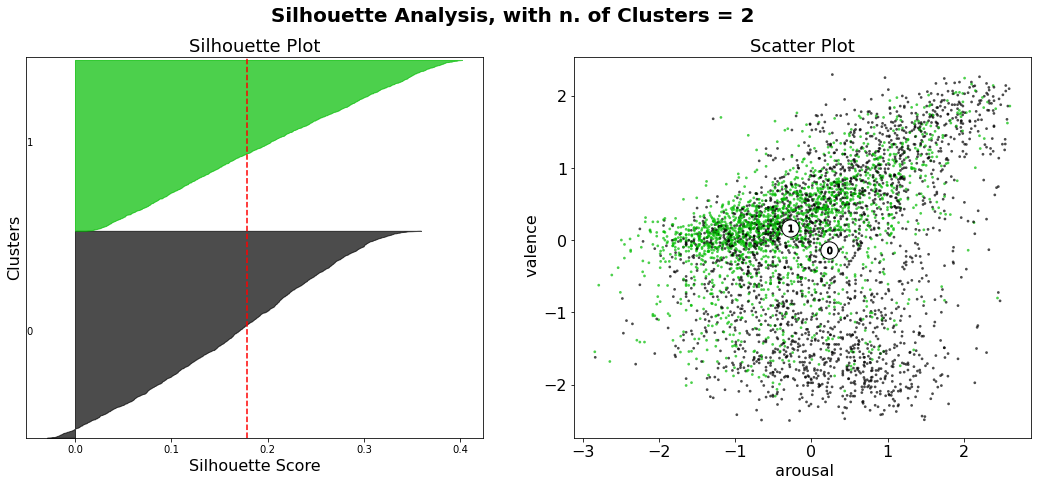

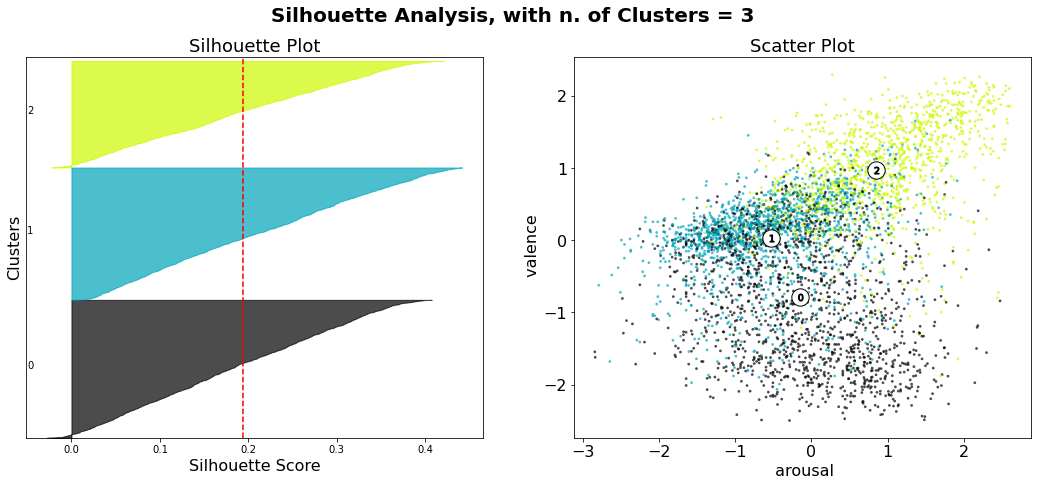

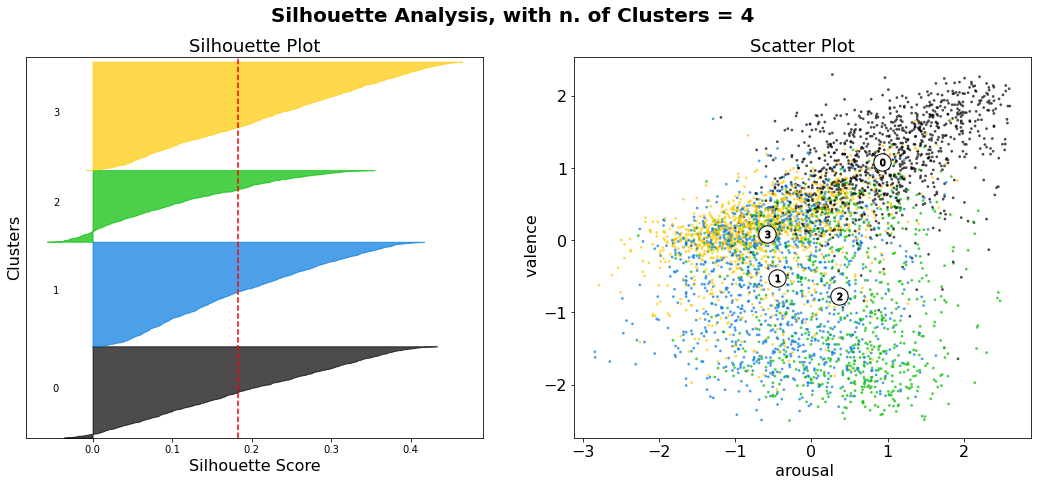

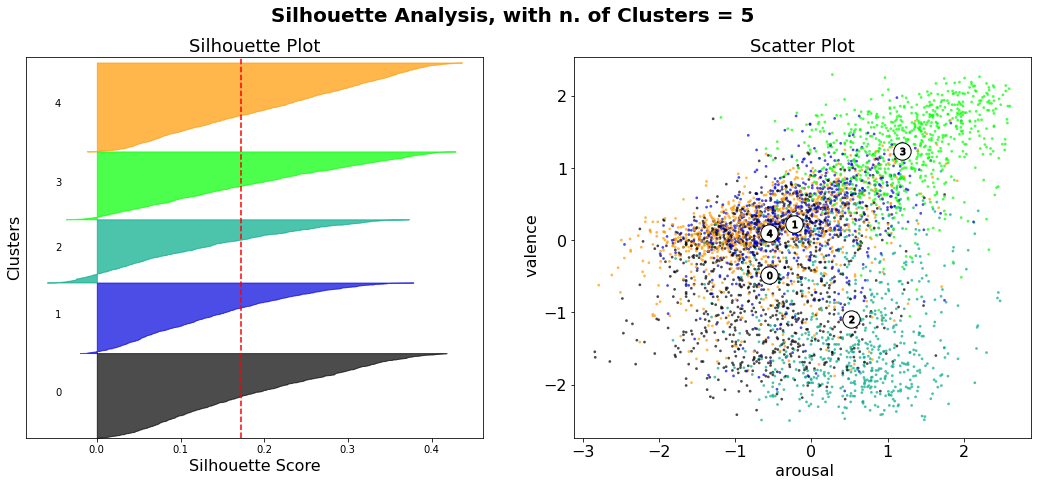

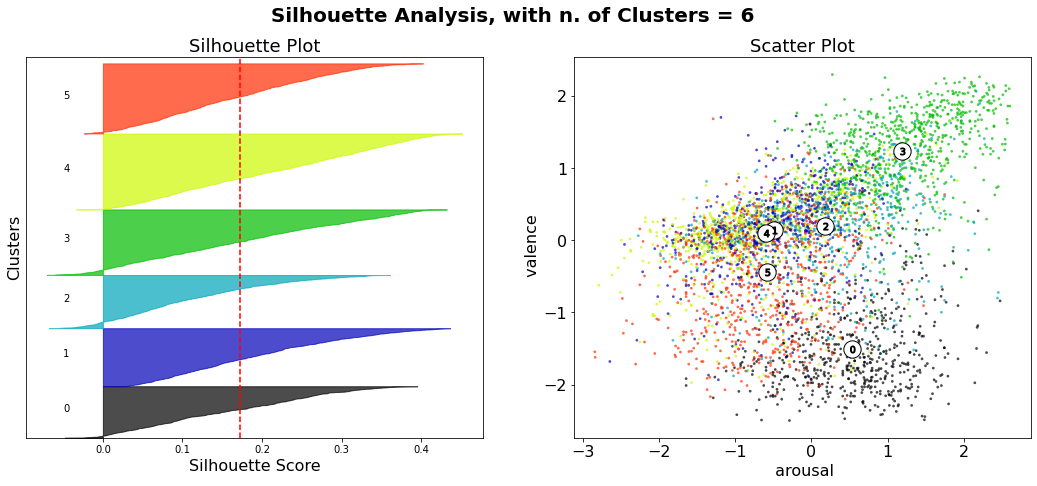

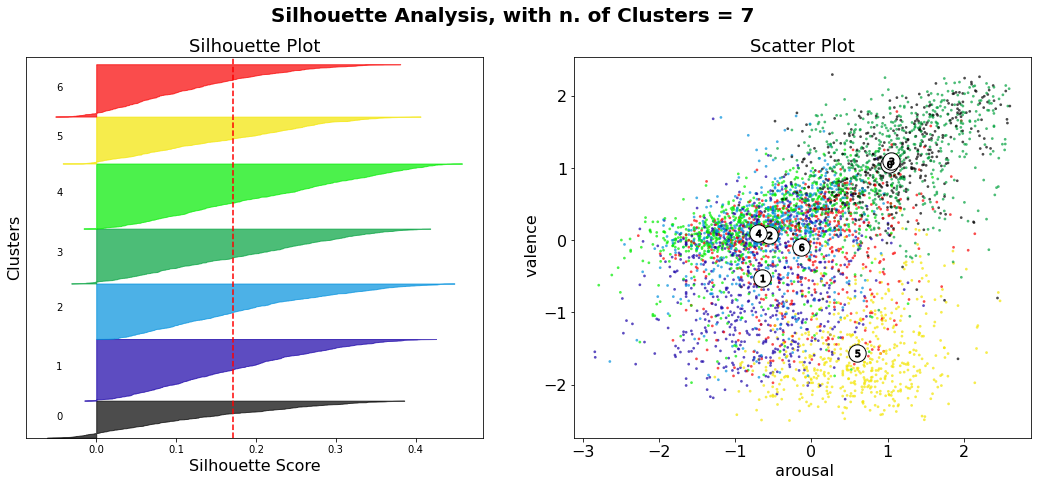

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

a=0
b=1

range_n_clusters = [2, 3, 4, 5, 6,7]
for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # The 1st subplot is the silhouette plot
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_stand_array) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    cluster_labels = clusterer.fit_predict(df_stand_array)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_stand_array, cluster_labels)
    print("N. of Clusters: ", n_clusters,"Average Silhouette Score: ",silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_stand_array, cluster_labels)
    y_ticks = []
    y_lower =  y_upper = 0
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color,
                          edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower += len(ith_cluster_silhouette_values) 
        
    ax1.set_title("Silhouette Plot", fontsize = 18)
    ax1.set_xlabel("Silhouette Score", fontsize = 16)
    ax1.set_ylabel("Clusters", fontsize = 16)      
         
    avg_score = np.mean(silhouette_avg)     
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(avg_score, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    ax2.scatter(df_stand_array[:, a], df_stand_array[:, b], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, a], centers[:, b], marker="o", c="white", alpha=1, s=300, edgecolor="k")

    for i, c in enumerate(centers):
        ax2.scatter(c[a], c[b], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Scatter Plot", fontsize = 18)
    ax2.set_xlabel(" "+cols[a], fontsize = 16)
    ax2.set_ylabel(" "+cols[b], fontsize = 16)
    
    plt.suptitle(
        "Silhouette Analysis, with n. of Clusters = %d"
        % n_clusters,
        fontsize=20,           
        fontweight="bold",
        )
    plt.xticks(fontsize = 16)      
    plt.yticks(fontsize = 16) 
plt.show()

## Clustering analysis by K-Means (8 pts)
 * Choice the attributes, identify the best value of k, characterize the clusters (w.r.t. centroid analysis and variable distribution within);


### 3 Clusters

In [ ]:
#df_stand = df_stand.drop(['cluster'], axis= 1)
#df_stand.head()

In [ ]:
kmeans_model = KMeans(n_clusters = 3, max_iter = 500, n_init=20)
kmeans_model.fit(df_stand)

In [ ]:
centroids = kmeans_model.cluster_centers_

In [ ]:
kmeans_model.cluster_centers_.shape

In [ ]:
kmeans_model.labels_

In [ ]:
df_stand["cluster"] = kmeans_model.labels_
df_stand.head()

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df_stand.columns)), df_stand.columns, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
sb.pairplot(data= df_stand, hue ="cluster", palette = "Accent")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

### 3 Clusters by 3 Attributes

In [ ]:
df_stand = df_stand.drop(['cluster', 'AOA', 'SIZE', 'GEND', 'WCF'], axis= 1)
df_stand.head()

In [ ]:
kmeans_model = KMeans(n_clusters = 3, max_iter = 500, n_init=20)
kmeans_model.fit(df_stand)

In [ ]:
centroids = kmeans_model.cluster_centers_

In [ ]:
kmeans_model.cluster_centers_.shape

In [ ]:
kmeans_model.labels_

In [ ]:
df_stand["cluster"] = kmeans_model.labels_
df_stand.head()

In [ ]:
df_stand.cluster.value_counts()

In [ ]:
plt.figure(figsize = (15,10))
sb.pairplot(data= df_stand, hue ="cluster", palette = "Accent")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

### 2.1.1- Parallel-coordinate plot w.r.t. mean values 

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df_stand.columns)), df_stand.columns, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### 2.1.2- Using Barchart in order to see the distribution of variables w.r.t. clusters 

In [ ]:
kmeans_model.labels_

In [ ]:
clust_name = ['A', 'B', 'C']

df_new['kmeans_labels'] = kmeans_model.labels_

bar_pl = df_new['polysemy'].groupby(df_new['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.xlabel('Clusters', fontsize = 18)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

In [ ]:
bar_pl = df_new['kmeans_labels'].groupby(df_new['polysemy']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='w', linewidth=1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Polysemy', fontsize = 18)
plt.xticks(rotation=0, fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In [ ]:
bar_pl = df_new['kmeans_labels'].groupby(df_new['length']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xlabel('Length', fontsize = 18)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(fontsize=16, rotation=0)

plt.plot()

In [ ]:
bar_pl = df_new['length'].groupby(df_new['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.xlabel('Clusters', fontsize = 18)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

### 6 Clusters

In [ ]:
#df_stand = df_stand.drop(['cluster'], axis= 1)
df_stand.head()

In [ ]:
kmeans_model = KMeans(n_clusters = 6, max_iter = 500, n_init=20)
kmeans_model.fit(df_stand)

In [ ]:
centroids = kmeans_model.cluster_centers_

In [ ]:
kmeans_model.cluster_centers_.shape

In [ ]:
kmeans_model.labels_

In [ ]:
df_stand["cluster"] = kmeans_model.labels_
df_stand.head()

In [ ]:
df_stand.cluster.value_counts()

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df_stand.columns)), df_stand.columns, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize = (15,10))
sb.pairplot(data= df_stand, hue ="cluster", palette = "Accent")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

In [ ]:
fig = plt.figure(figsize = (16,12))

x = 'arousal'
y = 'valence'
z = 'aoa'

ax = plt.axes(projection="3d")
ax.scatter(X_minmax[:,1], X_minmax[:,0], X_minmax[:,2], c=kmeans.labels_, marker='o')
#ax.scatter( centers[:,0], centers[:,1], centers[:,2], c='red', marker='+', s=200 )
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.show()

## Analysis by density-based clustering (8 pts)
 * Choice the attributes, identify the best parameter configuration, characterize clusters;

In [ ]:
#help(DBSCAN)

In [ ]:
#df_new = df_new.drop(['word', 'length', 'concreteness','dominance', 'familiarity', 'polysemy'], axis= 1)
#df_new.head()

In [ ]:
#df_stand.head()

In [ ]:
#df_stand_array

In [58]:
#dbscan = DBSCAN( eps=0.32, min_samples=20)
#dbscan.fit(df_stand_array)
#
#print(np.unique(dbscan.labels_, return_counts=True))
#
#dbscan = DBSCAN( eps=0.30, min_samples=6)
#dbscan.fit(df_stand_array)
#
#print(np.unique(dbscan.labels_, return_counts=True))

dbscan = DBSCAN( eps= 1.3, min_samples=14)
dbscan.fit(df_stand_array)

print(np.unique(dbscan.labels_, return_counts=True))

(array([-1,  0], dtype=int64), array([ 198, 4159], dtype=int64))


In [ ]:
#dbscan.labels_

In [55]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([  15, 4342], dtype=int64))

In [483]:
cols = df_new.columns
cols

Index(['arousal', 'valence', 'imageability', 'aoa', 'semsize', 'gender',
       'web_corpus_freq'],
      dtype='object')

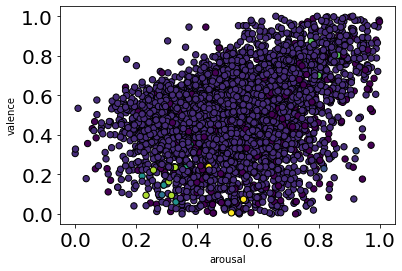

In [484]:
plt.scatter(df_minmax_array[:,0],df_minmax_array[:,2], s=40, edgecolor='black', c=dbscan.labels_)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.show()

In [ ]:
# min samples k = n of attributes multiplied by 2 (should be greater or equal to dimensions)

In [23]:
dist = pdist(df_stand_array, 'euclidean')
dist = squareform(dist)

k=14
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

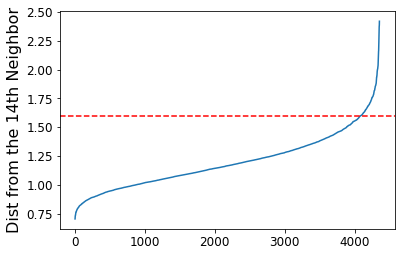

In [54]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('Dist from the 14th Neighbor', fontsize = 16)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.axhline(1.60, color = "r", linestyle='--') 
plt.show()

In [34]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
df_stand["label"] = dbscan.labels_
df_stand.head()

,AROU,VAL,IMAG,AOA,SIZE,GEND,WCF,label
0,-1.500641,0.448362,0.461439,0.844767,0.979334,-1.020821,-0.221199,0
1,-1.334147,0.105442,-1.126278,1.140978,-1.423344,-0.195815,-2.077273,0
2,-0.373314,-0.852279,-1.610579,1.699408,0.546578,1.281291,-2.143269,0
3,-0.722602,-0.779304,-1.570281,1.840229,0.942129,0.545208,-2.125901,0
4,0.122626,0.257851,1.114257,1.071377,-0.579371,0.581024,-0.788835,0


In [44]:
# finding noise points 
(df_stand[df_stand["label"] == -1])

,AROU,VAL,IMAG,label
108,-0.952683,0.246872,-1.278675,-1
573,0.355813,1.064455,1.351645,-1
763,2.150244,1.007625,1.318675,-1
882,-2.494187,0.004697,1.075425,-1
965,0.304218,-1.879102,1.193386,-1
1333,1.747085,0.635644,-1.147525,-1
1491,2.441140,-0.799324,1.386081,-1
1896,1.066837,-1.680195,0.720075,-1
3015,-0.091271,-1.689236,0.942077,-1
3246,2.143473,0.091880,0.188150,-1


In [37]:
df_stand = df_stand.drop(['AOA', 'SIZE', 'GEND', 'WCF'], axis = 1)
df_stand.head()

,AROU,VAL,IMAG,label
0,-1.500641,0.448362,0.461439,0
1,-1.334147,0.105442,-1.126278,0
2,-0.373314,-0.852279,-1.610579,0
3,-0.722602,-0.779304,-1.570281,0
4,0.122626,0.257851,1.114257,0


<Figure size 1080x720 with 0 Axes>

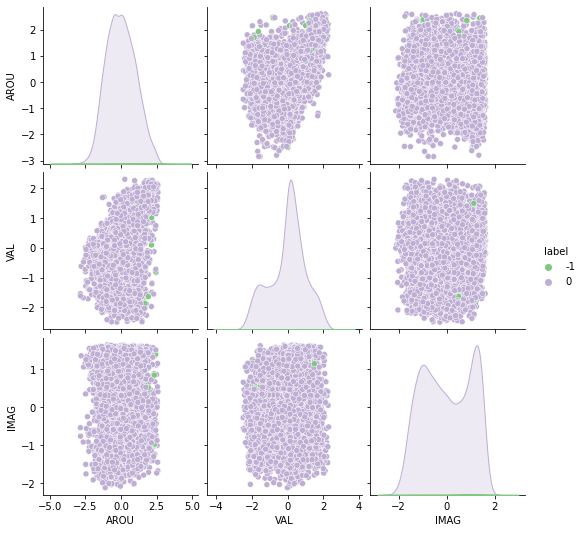

In [51]:
plt.figure(figsize = (15,10))
sb.pairplot(data= df_stand, hue ="label", palette = "Accent")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

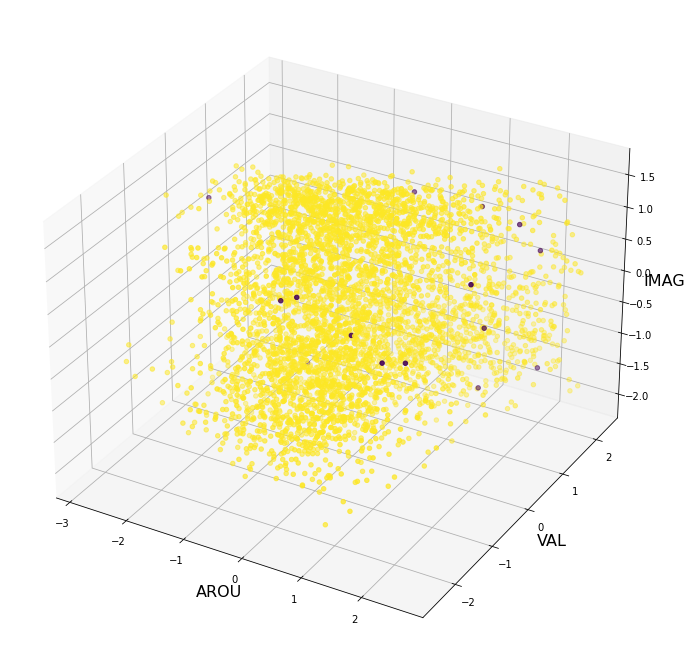

In [49]:
fig = plt.figure(figsize = (16,12))
x = 'AROU'
y = 'VAL'
z = 'IMAG'
ax = plt.axes(projection="3d")
ax.scatter(df_stand_array[:,0], df_stand_array[:,1], df_stand_array[:,2], c=dbscan.labels_, marker='o')
#ax.scatter( centers[:,0], centers[:,1], centers[:,2], c='red', marker='+', s=200 )
ax.set_xlabel(x, fontsize = 16)
ax.set_ylabel(y, fontsize = 16)
ax.set_zlabel(z, fontsize = 16)
plt.show()

## Hierarchical Clustering

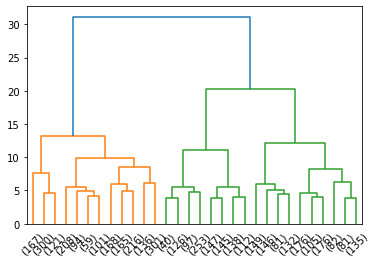

In [549]:
data_dist = pdist(df_minmax_array, metric='euclidean')
data_link = linkage(data_dist, method='ward')
res = dendrogram(data_link, truncate_mode='lastp') #, above_threshold_color='#bcbddc', orientation='top'

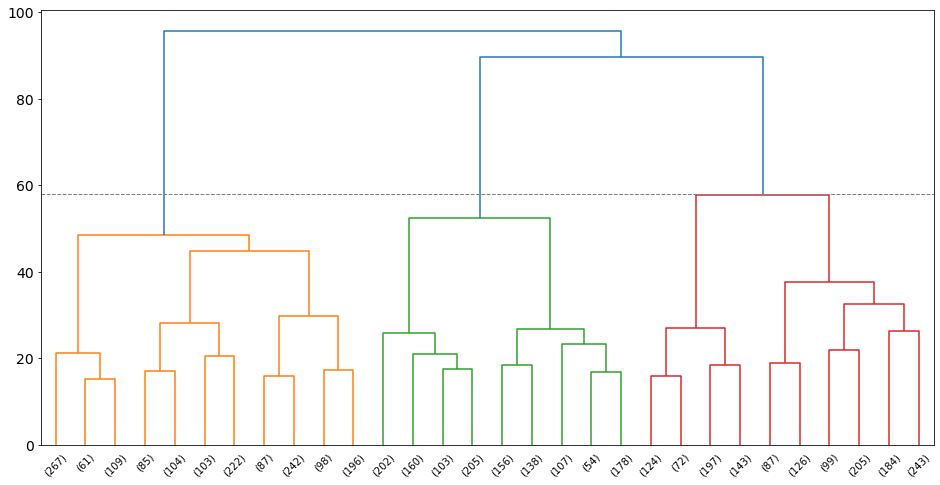

In [569]:
data_dist = pdist(df_stand_array, metric='euclidean')
data_link = linkage(data_dist, method='ward')
plt.figure(figsize = (16, 8))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.axhline(y=58, c='grey', lw=1, linestyle='dashed')
res = dendrogram(data_link, truncate_mode='lastp')

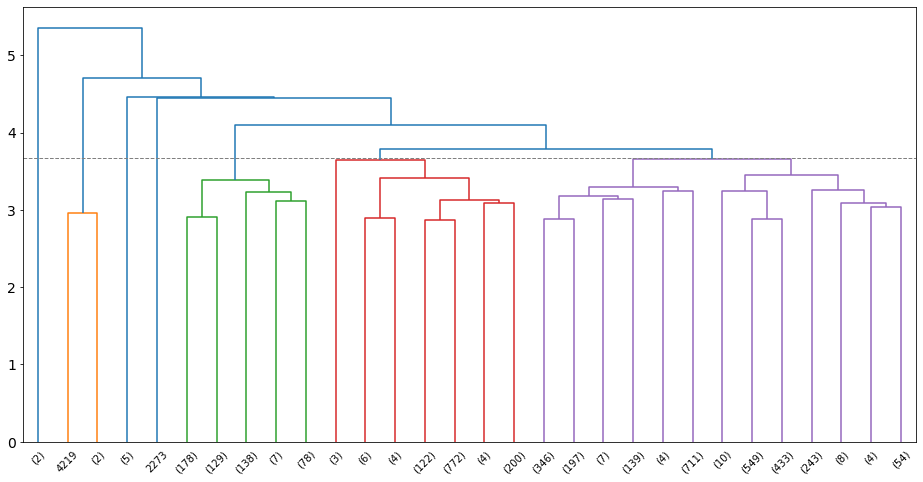

In [576]:
data_dist = pdist(df_stand, metric='euclidean')
data_link = linkage(data_dist, method='average')
plt.figure(figsize = (16, 8))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 14)
plt.axhline(y=3.67, c='grey', lw=1, linestyle='dashed')
res = dendrogram(data_link, truncate_mode='lastp')

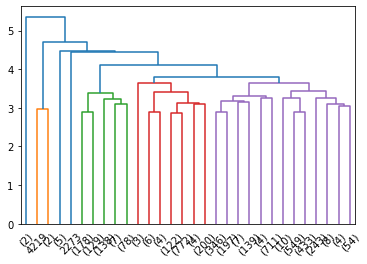

In [572]:
data_dist = pdist(df_stand_array, metric='euclidean')
data_link = linkage(data_dist, method='average')
res = dendrogram(data_link, truncate_mode='lastp')

In [44]:
hier1 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
hier1.fit(df_stand_array)
hier2 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hier2.fit(df_stand_array)
hier3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single')
hier3.fit(df_stand_array)
hier4 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hier4.fit(df_stand_array)

AgglomerativeClustering(n_clusters=3)

In [409]:
hier.labels_

array([2, 2, 2, ..., 0, 2, 2], dtype=int64)

In [ ]:
## ?????
#hier = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='single')
#hier.fit( dist )

In [45]:
print('__________________________________')
print('Hierarchical (Average)')
print('Silhouette', silhouette_score(df_stand_array, hier1.labels_))
print('__________________________________')
print('Hierarchical (Complete)')
print('Silhouette', silhouette_score(df_stand_array, hier2.labels_))
print('__________________________________')
print('Hierarchical (Single)')
print('Silhouette', silhouette_score(df_stand_array, hier3.labels_))
print('__________________________________')
print('Hierarchical (Ward)')
print('Silhouette', silhouette_score(df_stand_array, hier4.labels_))
print('__________________________________')

__________________________________
Hierarchical (Average)
Silhouette 0.16144969770159015
__________________________________
Hierarchical (Complete)
Silhouette 0.06041452481329562
__________________________________
Hierarchical (Single)
Silhouette 0.16510109801485207
__________________________________
Hierarchical (Ward)
Silhouette 0.15886594339450255
__________________________________


## EVALUATION

In [398]:
print('__________________________________________________________')
print('K-means')
print(np.unique(kmeans_model.labels_, return_counts=True))
print('__________________________________________________________')
print('Dbscan')
print(np.unique(dbscan.labels_, return_counts=True))
print('__________________________________________________________')

__________________________________________________________
K-means
(array([0, 1, 2]), array([1557, 1644, 1156], dtype=int64))
__________________________________________________________
Dbscan
(array([-1,  0,  1], dtype=int64), array([ 428, 3918,   11], dtype=int64))
__________________________________________________________


In [53]:
#print('__________________________________')
#print('K-means')
##print('SSE', kmeans_model.inertia_)
#print('Silhouette', silhouette_score(df_stand, kmeans_model.labels_))
#print('__________________________________')
#print('Dbscan')
#print('SSE', dbscan.inertia_)
print('Silhouette', silhouette_score(df_stand, dbscan.labels_))
print('__________________________________')
print('Hierarchical')
##print('SSE', hier.inertia_)
#print('Silhouette', silhouette_score(df_stand, hier1.labels_))
#print('__________________________________')
#

Silhouette 0.24187378126700385
__________________________________
Hierarchical
